# MUSIC GENRE CLASSIFICATION

Fonte: https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#esc-50_dataset

### 1. Importação da YAMNet

In [2]:
!pip install tensorflow_io
!pip install tensorflow_hub

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from utils import get_train_val_set_data

### 2. Carregamento dos dados 

#### Apresentando um exemplo de áudio

In [2]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

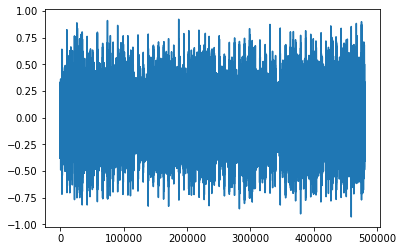

In [3]:
testing_wav_data = load_wav_16k_mono('../dataset/Data/genres_original/rock/rock.00053.wav')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

#### Carregando todos os arquivos de áudio

In [4]:
path_name = '../dataset/Data/genres_original/'

In [5]:
file_path = []
song_name = []
genre_list = []

for genre in os.listdir(path_name):  
  for song in os.listdir(path_name + genre):
    try: 
      file_path.append(path_name + genre + '/'+ song)
      song_name.append(song)
      genre_list.append(genre)
    except:
      print(f"Arquivo corrompido: {song}")

In [6]:
import pandas as pd
wavDataFrame = pd.DataFrame({
    'filename': song_name,
    'wav_file': file_path,
    'label': genre_list
})

In [7]:
wavDataFrame = wavDataFrame[wavDataFrame['filename'] != 'jazz.00054.wav']

In [8]:
wavDataFrame.head()


,filename,wav_file,label
0,blues.00000.wav,../dataset/Data/genres_original/blues/blues.00...,blues
1,blues.00001.wav,../dataset/Data/genres_original/blues/blues.00...,blues
2,blues.00002.wav,../dataset/Data/genres_original/blues/blues.00...,blues
3,blues.00003.wav,../dataset/Data/genres_original/blues/blues.00...,blues
4,blues.00004.wav,../dataset/Data/genres_original/blues/blues.00...,blues


#### Dividindo os dados em conjuntos de treino, validação e teste

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_set_data(wavDataFrame)

-- Treino --
X (shape):  (699, 2)
y:  699
-- Validação --
X (shape):  (150, 2)
y:  150
-- Teste --
X (shape):  (150, 2)
y:  150


In [12]:
wavDataFrame['filename'] = wavDataFrame.filename.apply(lambda x: x.replace('.', '')[:-3])

In [11]:
wavDataFrame['fold'] = np.where(
    wavDataFrame.filename.isin(X_train.filename),
    1,
    np.where(
      wavDataFrame.filename.isin(X_val.filename),
      2,
      3 
    )
)

In [13]:
wavDataFrame.fold.value_counts()

1    699
2    150
3    150
Name: fold, dtype: int64

In [14]:
wavDataFrame.label.unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

#### Processando os dados para modelagens

In [15]:
map_class_to_id = {
    'metal':0, 
    'country':1, 
    'reggae':2, 
    'blues':3, 
    'pop':4, 
    'hiphop':5, 
    'disco':6,
    'jazz':7, 
    'rock':8, 
    'classical':9
}

class_id = wavDataFrame['label'].apply(lambda name: map_class_to_id[name])

wavDataFrame = wavDataFrame.assign(label=class_id)

In [16]:
filenames = wavDataFrame['wav_file']
targets = wavDataFrame['label']
folds = wavDataFrame['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [17]:
from tqdm import tqdm

In [18]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [19]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [20]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()

In [21]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold == 1)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 2)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 3)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_np_wav = []
train_np_label = []

for element in tqdm(train_ds):
  train_np_wav.append(element[0].numpy())
  train_np_label.append(element[1].numpy())

1355it [09:37,  2.35it/s]


In [ ]:
val_np_wav = []
val_np_label = []

for element in tqdm(val_ds):
  val_np_wav.append(element[0].numpy())
  val_np_label.append(element[1].numpy())

291it [00:02, 128.60it/s]


In [ ]:
X_train = np.concatenate(train_np_wav)
y_train = np.concatenate(train_np_label)

X_val = np.concatenate(val_np_wav)
y_val = np.concatenate(val_np_label)

### 3. Aplicação de Transfer Learning

#### 3.1 Multi Layer Perceptron

In [ ]:
from keras.layers import BatchNormalization, Dropout
import keras.regularizers

In [ ]:
tf_mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_uniform'),
    BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
    BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    BatchNormalization(),
    Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
], name='my_model')

tf_mlp.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              102

In [ ]:
tf_mlp.compile(loss= 'sparse_categorical_crossentropy',
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = tf_mlp.fit(X_train, y_train,
                       epochs=50,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/50
1355/1355 [==============================] - 13s 10ms/step - loss: 0.2101 - accuracy: 0.9247 - val_loss: 1.4241 - val_accuracy: 0.7010
Epoch 2/50
1355/1355 [==============================] - 13s 9ms/step - loss: 0.1929 - accuracy: 0.9301 - val_loss: 1.4827 - val_accuracy: 0.6980
Epoch 3/50
1355/1355 [==============================] - 13s 9ms/step - loss: 0.1893 - accuracy: 0.9309 - val_loss: 1.5102 - val_accuracy: 0.6920
Epoch 4/50
1355/1355 [==============================] - 13s 9ms/step - loss: 0.1764 - accuracy: 0.9363 - val_loss: 1.5520 - val_accuracy: 0.7026
Epoch 5/50
1355/1355 [==============================] - 13s 9ms/step - loss: 0.1774 - accuracy: 0.9354 - val_loss: 1.5341 - val_accuracy: 0.7024
Epoch 6/50
1355/1355 [==============================] - 13s 10ms/step - loss: 0.1588 - accuracy: 0.9417 - val_loss: 1.5869 - val_accuracy: 0.7031
Epoch 7/50
1355/1355 [==============================] - 13s 9ms/step - loss: 0.1568 - accuracy: 0.9431 - val_loss: 1.5793 - val_

In [ ]:
tf_mlp.save('/content/weights_tf_mlp.h5')
#tf_mlp.model.load_weights('weights_tf_mlp.h5')

In [ ]:
import seaborn as sns
from sklearn import metrics

In [ ]:
tf_mlp.predict(X_train)[0]

array([2.0808160e-04, 6.1385217e-05, 1.9963968e-03, 1.1552913e-04,
       1.6531474e-05, 1.8495690e-08, 9.9748433e-01, 8.1606345e-08,
       1.1709202e-04, 4.5658089e-07], dtype=float32)

In [ ]:
labels = ['metal', 
'country', 
'reggae', 
'blues', 
'pop', 
'hiphop', 
'disco',
'jazz', 
'rock', 
'classical']

              precision    recall  f1-score   support

           0       0.87      0.80      0.84       930
           1       0.62      0.58      0.60       930
           2       0.68      0.62      0.65       930
           3       0.67      0.65      0.66       930
           4       0.65      0.72      0.68       930
           5       0.70      0.70      0.70       932
           6       0.66      0.63      0.64       932
           7       0.88      0.93      0.90       930
           8       0.38      0.43      0.41       931
           9       0.95      0.97      0.96       930

    accuracy                           0.70      9305
   macro avg       0.71      0.70      0.71      9305
weighted avg       0.71      0.70      0.71      9305

0.7043981688363827


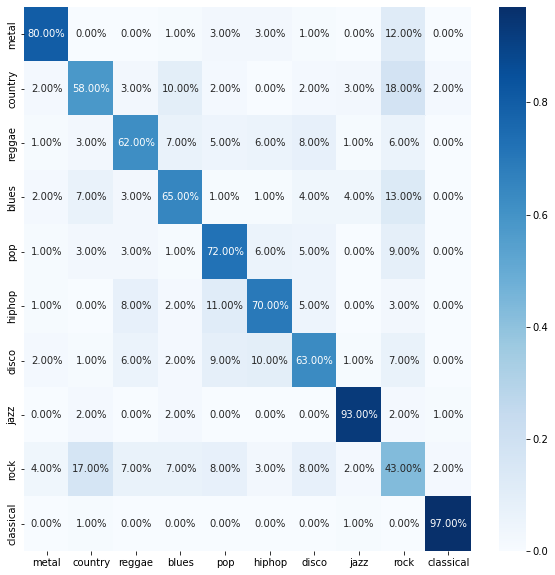

In [ ]:
resultados_mlp = np.argmax(tf_mlp.predict(X_val), axis=1)
print(metrics.classification_report(y_val,resultados_mlp))
print(metrics.balanced_accuracy_score(y_val, resultados_mlp))

matrix = metrics.confusion_matrix(y_val, np.argmax(tf_mlp.predict(X_val), axis=1) , normalize = 'true').round(2)
sns.heatmap(matrix, cmap = 'Blues', annot = True, fmt = '.2%', xticklabels= labels, yticklabels= labels)
plt.rcParams['figure.figsize'] = (10, 10)

In [ ]:
def plot_balanced_accuracy_heatmap(y, y_pred, labels = le.classes_):

  print(f'Acurácia balanceada:{balanced_accuracy_score(y, y_pred)}\n')

  plt.figure(figsize=(10,10))
  sns.heatmap(
      confusion_matrix(y, y_pred, normalize='true').round(2), 
      cmap='Blues', 
      annot=True,
      xticklabels=le.classes_, 
      yticklabels=le.classes_
  )
  plt.show()

#### 3.2 SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import joblib

In [ ]:
clf_svm = SVC(
    kernel = 'rbf',
    verbose = 2,
    random_state = 42
)

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

std_scaler.fit(X_train)

X_train_scaled = std_scaler.transform(X_train)
X_val_scaled = std_scaler.transform(X_val)

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC as svc 
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats

In [ ]:
clf_svm.fit(
    X_train_scaled, 
    y_train
)

[LibSVM]

SVC(random_state=42, verbose=2)

In [ ]:
import joblib

with open('SVMTransferLearningYamnet.joblib.pkl', 'wb') as f:
    joblib.dump(clf_svm, f, compress=9)

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics

              precision    recall  f1-score   support

           0       0.91      0.84      0.88       930
           1       0.60      0.65      0.62       930
           2       0.64      0.54      0.58       930
           3       0.66      0.65      0.65       930
           4       0.66      0.76      0.71       930
           5       0.69      0.71      0.70       932
           6       0.66      0.70      0.68       932
           7       0.91      0.91      0.91       930
           8       0.47      0.42      0.44       931
           9       0.95      0.98      0.96       930

    accuracy                           0.72      9305
   macro avg       0.71      0.72      0.71      9305
weighted avg       0.71      0.72      0.71      9305

0.7153513751150686


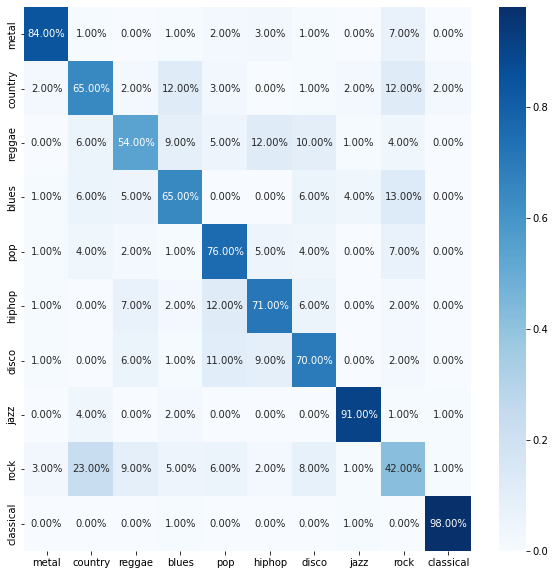

In [ ]:
resultados_svm = clf_svm.predict(X_val_scaled)
print(metrics.classification_report(y_val,resultados_svm))
print(metrics.balanced_accuracy_score(y_val, resultados_svm))

matrix = metrics.confusion_matrix(y_val, resultados_svm , normalize = 'true').round(2)
sns.heatmap(matrix, cmap = 'Blues', annot = True, fmt = '.2%', xticklabels= labels, yticklabels= labels)
plt.rcParams['figure.figsize'] = (10, 10)